#CONEXIÓN Y LECTURA BD

## Conexión BD

In [6]:
# Montar drive y crear path para sys y para directorio de trabajo

from google.colab import drive
drive.mount('/content/drive')

import sys
import os

# Define el path al directorio de trabajo actual
path = "/content/drive/My Drive/cod/analitica_salud"


sys.path.append(path) ### para importar archivo de funciones propias a través de import

os.chdir(path) ### para que por defecto suba y descargue archivos partiendo de esa ruta

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Cargar Librerías

In [7]:
!pip install --quiet optuna

In [8]:
!pip install onnx skl2onnx onnxruntime

In [26]:
import pandas as pd
import numpy as np
import graphviz
import optuna
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import time  # Para medir tiempos de inferencia
import onnx  # Para guardar y manejar el modelo en formato ONNX
import onnxruntime as ort  # Para ejecutar el modelo ONNX (se instala con: pip install onnxruntime)


from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.linear_model import LogisticRegression
from skl2onnx.common.data_types import FloatTensorType

# Importar librerías para conversión a ONNX
from skl2onnx import to_onnx



##Acceso Notebook

In [10]:
salud_model= pd.read_csv('data/salud_modelado_final.csv')
salud_model.head()

,gender,cholesterol_2,cholesterol_3,gluc_2,gluc_3,smoke,alco,active,age,height,weight,ap_hi,ap_lo,cardio
0,1,0,0,0,0,0,0,1,0.600000,0.600000,0.192982,0.153846,0.50,0
1,0,0,1,0,0,0,0,1,0.742857,0.200000,0.596491,0.615385,0.75,1
2,0,0,1,0,0,0,0,0,0.628571,0.500000,0.228070,0.461538,0.25,1
3,1,0,0,0,0,0,0,1,0.542857,0.633333,0.543860,0.769231,1.00,1
4,0,0,0,0,0,0,0,0,0.514286,0.200000,0.087719,0.000000,0.00,0


# Modelo

En un contexto clínico como el diagnóstico de enfermedades cardiovasculares, utilizar la métrica F1-score puede ser una elección más equilibrada cuando se desea mantener un compromiso entre identificar correctamente a los pacientes enfermos (recall) y evitar alarmas innecesarias en personas sanas (precisión).  En el ámbito médico, un falso negativo puede ser peligroso porque omite a un paciente enfermo, pero un exceso de falsos positivos también puede generar ansiedad, gastos innecesarios y sobrecarga en el sistema de salud. Por ello, si se busca un enfoque más equilibrado que considere tanto la sensibilidad como la precisión, el F1-score permite evaluar mejor el rendimiento global del modelo, sin favorecer excesivamente a una sola dimensión del problema.

Se analizaran tres modelos y se seleccionará como métrica el f1 score.

## Regresión Logística

In [11]:
x = salud_model.drop("cardio", axis=1)

y = salud_model["cardio"]

x_train,x_test,y_train,y_test = train_test_split(x,y,shuffle = True,test_size=0.30, random_state=123)


model = LogisticRegression() # definir el modelo
model.fit(x_train,y_train) # entrenar el modelo

y_pred_train = model.predict(x_train) # guardar la predicción para train
y_pred_test = model.predict(x_test) # guardar la predicción para test


y_pred_test # predicción de test
y_test # realidad de test

,cardio
52751,1
28203,0
42946,0
45738,0
5086,0
...,...
6471,1
21495,1
13220,1
18854,1


### Metricas de Desempeño

[[17364  4442]
 [ 7323 13295]]


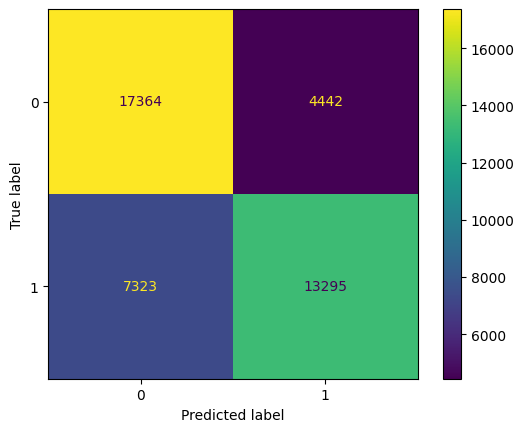

In [12]:
# metricas de entrenamiento
cm1 = confusion_matrix(y_train, y_pred_train, labels=model.classes_) # guardar las clases para la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm1,display_labels=model.classes_)
disp.plot();
print(cm1)

**Análisis de la matriz de confusión entrenamiento**
* La matriz de confusión indica el desempeño del modelo de clasificación

* Métricas calculadas:
* Accuracy: ≈ 75.4%   --> (TP + TN) / Total
- Precision (clase 1): ≈ 74.9%   --> TP / (TP + FP)
- Recall (Sensibilidad): ≈ 64.5%   --> TP / (TP + FN)
- F1 Score: ≈ 69.3%   --> Media armónica de precision y recall

* Conclusión:
- Buen desempeño general del modelo.
- Puede mejorarse el recall para reducir falsos negativos (FN), importante si los positivos son críticos, por ejemplo en este caso que es de  diagnóstico médico


In [13]:
TP=cm1[1,1] # el modelo dijo que eran 1 y en la realidad son 1, verdaderos positivos - 446
FP=cm1[0,1] # el modelo dijo que eran 1, en la realidad son 0, falsos positivos - 49
FN=cm1[1,0] # el modelo dijo que eran 0, en la realidad son 1, falsos negativos - 63
TN=cm1[0,0] # el modelo dijo que eran 0 y en la realidad son 0, verdaderos negativos - 723

print(f"Accuracy train: {accuracy_score(y_train, y_pred_train)}")
print(f'Precicion: {TP/(TP+FP)}')
print(f'Recall (Sensibilidad)): {TP/(TP+FN)}')
print(f'F1-score:', f1_score(y_train, y_pred_train, average='binary'))
print(f'Especificidad: {TN/(FP+TN)}')

Accuracy train: 0.7226805581746182
Precicion: 0.7495630602694932
Recall (Sensibilidad)): 0.6448249102725774
F1-score: 0.6932603311171947
Especificidad: 0.7962945978171145


[[7284 1906]
 [3183 5810]]


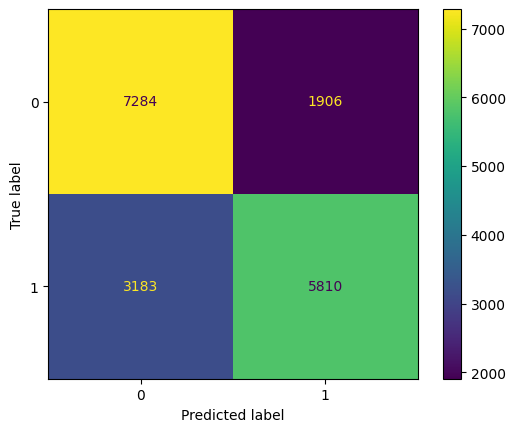

In [14]:
# Matriz de confusión:
cm = confusion_matrix(y_test, y_pred_test, labels=model.classes_) # guardar las clases para la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot();
print(cm)

In [15]:
#metricas de testeo
TP=cm[1,1] # el modelo dijo que eran 1 y en la realidad son 1, verdaderos positivos - 446
FP=cm[0,1] # el modelo dijo que eran 1, en la realidad son 0, falsos positivos - 49
FN=cm[1,0] # el modelo dijo que eran 0, en la realidad son 1, falsos negativos - 63
TN=cm[0,0] # el modelo dijo que eran 0 y en la realidad son 0, verdaderos negativos - 723

print(f"Accuracy test: {accuracy_score(y_test, y_pred_test)}")
print(f'Precicion: {TP/(TP+FP)}')
print(f'Recall (Sensibilidad)): {TP/(TP+FN)}')
print(f'F1-score:', f1_score(y_test, y_pred_test, average='binary'))
print(f'Especificidad: {TN/(FP+TN)}')

Accuracy test: 0.7201231919925205
Precicion: 0.7529808190772421
Recall (Sensibilidad)): 0.6460580451462249
F1-score: 0.6954335986594051
Especificidad: 0.7926006528835691


## Árbol de Decisión

In [16]:
salud_arbol=salud_model.copy()
salud_arbol.head()

,gender,cholesterol_2,cholesterol_3,gluc_2,gluc_3,smoke,alco,active,age,height,weight,ap_hi,ap_lo,cardio
0,1,0,0,0,0,0,0,1,0.600000,0.600000,0.192982,0.153846,0.50,0
1,0,0,1,0,0,0,0,1,0.742857,0.200000,0.596491,0.615385,0.75,1
2,0,0,1,0,0,0,0,0,0.628571,0.500000,0.228070,0.461538,0.25,1
3,1,0,0,0,0,0,0,1,0.542857,0.633333,0.543860,0.769231,1.00,1
4,0,0,0,0,0,0,0,0,0.514286,0.200000,0.087719,0.000000,0.00,0


In [17]:

# dividir en independientes y dependiente
X, y = salud_arbol.drop('cardio', axis = 1), salud_arbol['cardio']

# definir modelo
clf = tree.DecisionTreeClassifier(max_depth=10, random_state=123) #, class_weight='balanced', #
# dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123, test_size= 0.3)

# entrenar modelo
clf = clf.fit(X_train, y_train)

Se elige un valor de max_depth=10 para limitar la profundidad del árbol y así evitar el sobreajuste, lo cual es especialmente importante en problemas clínicos donde se busca que el modelo generalice bien a nuevos pacientes y no solo aprenda patrones específicos del conjunto de entrenamiento

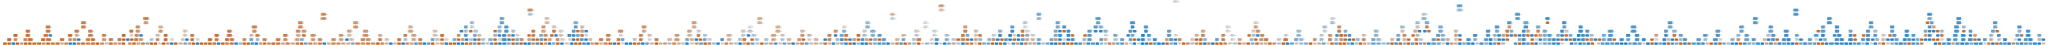

In [18]:
# Convertir los valores únicos de y a cadenas
class_names = [str(cls) for cls in y.unique()]

# Generar el gráfico

dot_data = tree.export_graphviz(clf,
                                feature_names=X.columns,  # Cambiado a X.columns
                                class_names=class_names,  # Cambiado a la lista de clases
                                filled=True, rounded=True,
                                special_characters=True)

graph = graphviz.Source(dot_data)
graph

### Métricas de Desempeño

In [19]:
# hacer la predicción sobre train
clf = clf.fit(X_train, y_train)
y_true = clf.predict(X_train)
print(metrics.classification_report(y_train, y_true, digits = 3))

              precision    recall  f1-score   support

           0      0.728     0.812     0.768     21806
           1      0.774     0.680     0.724     20618

    accuracy                          0.748     42424
   macro avg      0.751     0.746     0.746     42424
weighted avg      0.750     0.748     0.746     42424



In [20]:
# hacer la predicción sobre test
clf = clf.fit(X_train, y_train)
y_true = clf.predict(X_test)
print(metrics.classification_report(y_test, y_true, digits = 3))

              precision    recall  f1-score   support

           0      0.695     0.784     0.737      9190
           1      0.746     0.648     0.693      8993

    accuracy                          0.717     18183
   macro avg      0.720     0.716     0.715     18183
weighted avg      0.720     0.717     0.715     18183



## Bosque Aleatorio

In [21]:
salud_forest=salud_model.copy()
salud_forest

,gender,cholesterol_2,cholesterol_3,gluc_2,gluc_3,smoke,alco,active,age,height,weight,ap_hi,ap_lo,cardio
0,1,0,0,0,0,0,0,1,0.600000,0.600000,0.192982,0.153846,0.50,0
1,0,0,1,0,0,0,0,1,0.742857,0.200000,0.596491,0.615385,0.75,1
2,0,0,1,0,0,0,0,0,0.628571,0.500000,0.228070,0.461538,0.25,1
3,1,0,0,0,0,0,0,1,0.542857,0.633333,0.543860,0.769231,1.00,1
4,0,0,0,0,0,0,0,0,0.514286,0.200000,0.087719,0.000000,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60602,0,0,0,0,0,0,0,1,0.685714,0.733333,0.333333,0.461538,0.75,1
60603,0,0,0,0,0,0,0,1,0.800000,0.500000,0.508772,0.769231,0.50,1
60604,1,0,0,0,0,1,0,1,0.657143,0.600000,0.438596,0.307692,0.50,0
60605,0,0,0,1,0,0,0,0,0.914286,0.433333,0.368421,0.538462,0.50,1


In [22]:
X, y = salud_forest.drop('cardio', axis = 1), salud_forest['cardio']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123, test_size= 0.3)

In [23]:
# Crear el modelo
model = RandomForestClassifier(n_estimators=150,  # número de árboles
                               criterion='gini',
                               max_depth=10,  # estrategia de parada
                               min_samples_leaf=5,
                               max_features=None,
                               oob_score=False,
                               n_jobs=-1,
                               random_state=123)

# Entrenar el modelo
model.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, max_features=None, min_samples_leaf=5,
                       n_estimators=150, n_jobs=-1, random_state=123)

Se elige n_estimators=150 para tener suficientes árboles que mejoren la estabilidad y el poder predictivo del bosque sin que el tiempo de entrenamiento sea excesivo. El max_depth=10 limita la complejidad de cada árbol, ayudando a evitar sobreajuste y mejorar la generalización en un dataset grande pero con posibles ruidos. min_samples_leaf=5 asegura que cada hoja tenga un mínimo de datos, lo que también previene que el modelo aprenda patrones muy específicos y poco generalizables. Se usa max_features=None para que cada árbol considere todas las variables al buscar divisiones, maximizando la capacidad de encontrar las mejores de esstas.

### Métricas de Desempeño

In [24]:
# Calcular y mostrar las métricas en el conjunto de entrenamiento
print(metrics.classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.74      0.81      0.77     21806
           1       0.77      0.69      0.73     20618

    accuracy                           0.75     42424
   macro avg       0.75      0.75      0.75     42424
weighted avg       0.75      0.75      0.75     42424



In [25]:
# Calcular y mostrar las métricas en el conjunto de prueba
print(metrics.classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      9190
           1       0.75      0.67      0.71      8993

    accuracy                           0.73     18183
   macro avg       0.73      0.73      0.73     18183
weighted avg       0.73      0.73      0.73     18183



## Eleccion del mejor modelo

Comparando los tres modelos evaluados, se observa que el modelo de Bosque Aleatorio presenta el mejor desempeño general.

Comparación de F1-score (solo test):
Regresión logística:	0.695
Árbol de decisión:	0.715
Bosque aleatorio:	0.73

Conclusión:

Bosque Aleatorio es el mejor si se toma el F1-score como métrica. Indica que tiene un buen equilibrio: no diagnostica de más ni de menos con tanta frecuencia como los otros.

El árbol de decisión también tuvo un rendimiento aceptable, pero su *f1-score* fue ligeramente inferior al de Bosque Aleatorio.

Por lo tanto, se elige el **modelo de Bosque Aleatorio** como el más adecuado para este problema, por ofrecer un mejor balance entre precisión y sensibilidad.

## Optimización de Hiperparámetros

Se selecciona el modelo de bosque aleatorio para optimización de hiperparámetros

In [28]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5)
    }

    model = RandomForestClassifier(**params, random_state=123)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring="f1").mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)


[I 2025-06-08 23:11:41,701] A new study created in memory with name: no-name-9b535ad8-6b02-4048-a710-d58d48d62317
[I 2025-06-08 23:11:45,985] Trial 0 finished with value: 0.6926881997182229 and parameters: {'n_estimators': 128, 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 1}. Best is trial 0 with value: 0.6926881997182229.
[I 2025-06-08 23:11:48,843] Trial 1 finished with value: 0.693154848731678 and parameters: {'n_estimators': 85, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 4}. Best is trial 1 with value: 0.693154848731678.
[I 2025-06-08 23:11:52,742] Trial 2 finished with value: 0.7009905549478029 and parameters: {'n_estimators': 66, 'max_depth': 12, 'max_features': 'log2', 'min_samples_leaf': 1}. Best is trial 2 with value: 0.7009905549478029.
[I 2025-06-08 23:12:31,338] Trial 3 finished with value: 0.6960711729993933 and parameters: {'n_estimators': 198, 'max_depth': 14, 'max_features': None, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.7009

Estos rangos y opciones para optimizar hiperparámetros en el bosque aleatorio se seleccionan para explorar un equilibrio adecuado entre complejidad y generalización: n_estimators de 50 a 200 permite probar desde modelos rápidos y simples hasta más robustos con más árboles; max_depth entre 5 y 20 controla la profundidad para evitar sobreajuste o subajuste; max_features con opciones como "sqrt", "log2" o None evalúa diferentes estrategias para seleccionar variables en cada división, y min_samples_leaf de 1 a 5 ayuda a controlar el tamaño mínimo de las hojas, mejorando la estabilidad del modelo. Esta búsqueda dirigida con optuna maximiza el F1, clave para equilibrar precisión y recall en problemas clínicos.

In [29]:

#Resultados
print(f"Best trial:")
print(f"  Value (Best F1): {study.best_value:.4f}")
print(f"  Params: {study.best_params}")


Best trial:
  Value (Best F1): 0.7028
  Params: {'n_estimators': 165, 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 4}


In [30]:
#Obtener los mejores parámetros
best_params = study.best_params

#Crear el modelo con esos parámetros
best_model = RandomForestClassifier(**best_params, random_state=123)

#Entrenarlo
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=16, min_samples_leaf=4, n_estimators=165,
                       random_state=123)

In [31]:
y_pred_test = best_model.predict(X_test)


In [ ]:
print(metrics.classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.74      0.81      0.77     21806
           1       0.77      0.69      0.73     20618

    accuracy                           0.75     42424
   macro avg       0.75      0.75      0.75     42424
weighted avg       0.75      0.75      0.75     42424



In [32]:
print(metrics.classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      9190
           1       0.75      0.67      0.71      8993

    accuracy                           0.73     18183
   macro avg       0.73      0.73      0.73     18183
weighted avg       0.73      0.73      0.73     18183



Los resultados obtenidos al optimizar los hiperparámetros del modelo de bosque aleatorio muestran mejoras leves en las métricas clave (precisión, recall, f1-score y exactitud) tanto en el conjunto de entrenamiento como en el de prueba. Estas ligeras mejoras reflejan que la optimización ayudó a ajustar mejor el modelo a los datos, consolidando un desempeño estable y consistente que puede ofrecer un balance adecuado entre la capacidad predictiva y la generalización.

Aunque los cambios no fueron muy grandes, esta pequeña mejora indica que el ajuste contribuyó a un desempeño ligeramente más afinado del modelo, favoreciendo su capacidad de generalización y predicción sin sacrificar estabilidad.



In [ ]:
joblib.dump(best_model, "salidas/best_rf_optuna.pkl")

['salidas/best_rf_optuna.pkl']

# Análisis mejor modelo

In [ ]:
# Cargar el modelo guardado
best_model = joblib.load("salidas/best_rf_optuna.pkl")

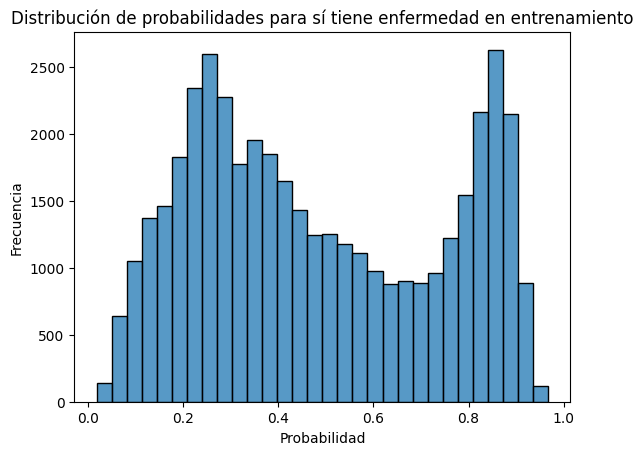

In [36]:
# Obtener probabilidades para la clase positiva en entrenamiento
probs_train = best_model.predict_proba(X_train)[:, 1]

# Visualizar la distribución de probabilidades en entrenamiento
sns.histplot(probs_train, bins=30, legend=False)
plt.title("Distribución de probabilidades para sí tiene enfermedad en entrenamiento")
plt.xlabel("Probabilidad")
plt.ylabel("Frecuencia")
plt.show()

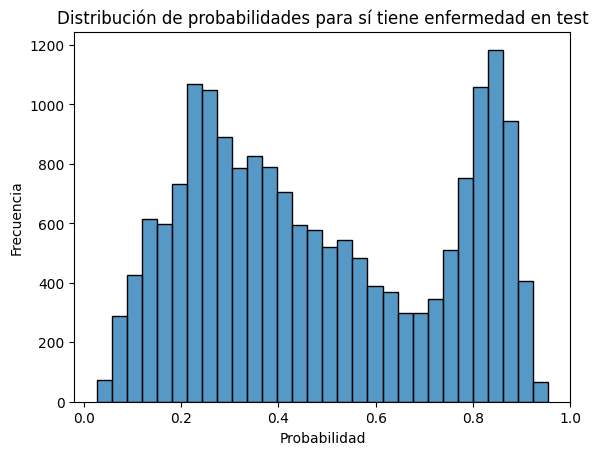

In [37]:


# Obtener probabilidades para la clase positiva (1)
probs = best_model.predict_proba(X_test)[:, 1]

# Visualizar la distribución de probabilidades
sns.histplot(probs, bins=30, legend=False)
plt.title("Distribución de probabilidades para sí tiene enfermedad en test")
plt.xlabel("Probabilidad")
plt.ylabel("Frecuencia")
plt.show()


Ambos histogramas presentan dos picos principales, uno cerca de 0.2–0.3 y otro cerca de 0.8–0.9 , esto indica que el modelo suele estar seguro al predecir si un paciente tiene o no tiene la enfermedad, asignando probabilidades extremas.

Hay menos ejemplos con probabilidades entre 0.4 y 0.6. Eso sugiere que el modelo no duda mucho al clasificar, lo cual es bueno si esas predicciones extremas son correctas.


Las formas de las distribuciones son muy parecidas entre los datos de entrenamiento y test. Esto es buena señal de que no hay sobreajuste aparente en la forma de las predicciones.

 En conjunto, estos resultados reflejan un buen desempeño y generalización del modelo.

[[18027  3779]
 [ 5817 14801]]


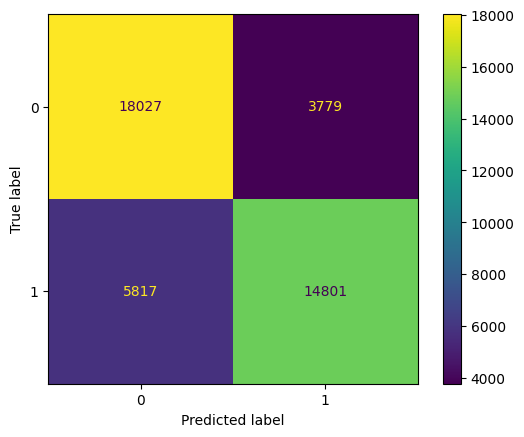

In [38]:
# Predicciones en entrenamiento y prueba
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# metricas de entrenamiento
cm1 = confusion_matrix(y_train, y_pred_train, labels=model.classes_) # guardar las clases para la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm1,display_labels=model.classes_)
disp.plot();
print(cm1)


In [42]:
TP=cm1[1,1] # el modelo dijo que eran 1 y en la realidad son 1, verdaderos positivos - 446
FP=cm1[0,1] # el modelo dijo que eran 1, en la realidad son 0, falsos positivos - 49
FN=cm1[1,0] # el modelo dijo que eran 0, en la realidad son 1, falsos negativos - 63
TN=cm1[0,0] # el modelo dijo que eran 0 y en la realidad son 0, verdaderos negativos - 723

print(f"Accuracy train: {accuracy_score(y_train, y_pred_train)}")
print(f'Precicion: {TP/(TP+FP)}')
print(f'Recall (Sensibilidad)): {TP/(TP+FN)}')
print(f'F1-score:', f1_score(y_train, y_pred_train, average='binary'))
print(f'Especificidad: {TN/(FP+TN)}')

Accuracy train: 0.7738072788987366
Precicion: 0.7966092572658773
Recall (Sensibilidad)): 0.7178678824328257
F1-score: 0.7551915914077248
Especificidad: 0.8266990736494543


[[7208 1982]
 [2976 6017]]


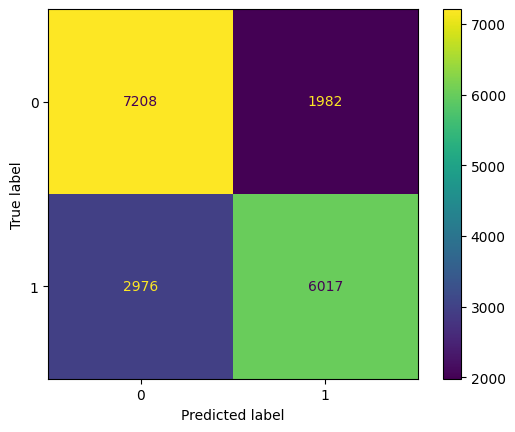

In [40]:
# Matriz de confusión: test
cm = confusion_matrix(y_test, y_pred_test, labels=model.classes_) # guardar las clases para la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot();
print(cm)

In [41]:
#metricas de testeo
TP=cm[1,1] # el modelo dijo que eran 1 y en la realidad son 1, verdaderos positivos - 446
FP=cm[0,1] # el modelo dijo que eran 1, en la realidad son 0, falsos positivos - 49
FN=cm[1,0] # el modelo dijo que eran 0, en la realidad son 1, falsos negativos - 63
TN=cm[0,0] # el modelo dijo que eran 0 y en la realidad son 0, verdaderos negativos - 723

print(f"Accuracy test: {accuracy_score(y_test, y_pred_test)}")
print(f'Precicion: {TP/(TP+FP)}')
print(f'Recall (Sensibilidad)): {TP/(TP+FN)}')
print(f'F1-score:', f1_score(y_test, y_pred_test, average='binary'))
print(f'Especificidad: {TN/(FP+TN)}')

Accuracy test: 0.7273277236979596
Precicion: 0.7522190273784223
Recall (Sensibilidad)): 0.6690759479595241
F1-score: 0.7082156308851224
Especificidad: 0.7843307943416757


**Según las métricas analizadas anteriormente:**

Las diferencias entre entrenamiento y test son moderadas y razonables (todas < 0.06), lo cual indica que: No hay overfitting (el modelo no memoriza), no hay underfitting grave (aprende patrones reales), Hay un buen ajuste general con ligera pérdida de rendimiento en testt|

 El modelo optimizado muestra un rendimiento balanceado y sólido con una precisión del 71% para la clase negativa ( no tiene enfermedad) y del 75% para la clase positiva (sí tiene enfermedad), alcanzando un F1-score global de 0.73.

 El modelo tiende ligeramente a predecir mejor la clase negativa (mayor recall) que es muy bueno para el diagnóstico clínico y también mantiene un buen equilibrio en ambas clases. La exactitud general del 73% indican que el modelo no está sesgado y se desempeña de forma estable frente a un dataset casi balanceado entre ambas clases ( no tiene enfermedad y si tiene enfermedad según lo visto en la exploración de datos). En conjunto con la distribución de probabilidades observada, estos resultados sugieren que el modelo generaliza bien y está listo para ser utilizado y desplegado.



El modelo está en una posición muy sólida para ser usado como sistema de apoyo a decisiones médicas preventivas. Con una accuracy del 73% y un F1 de 0.71 en test, generaliza bien, mantiene un buen equilibrio entre detectar enfermos (recall) y evitar falsos positivos (especificidad), lo que es crucial en la salud.

## Ajuste del umbral

In [64]:
probs_train = best_model.predict_proba(X_train)[:, 1]
probs_test = best_model.predict_proba(X_test)[:, 1]

Clasificación en TEST con umbral = 0.5
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      9190
           1       0.75      0.67      0.71      8993

    accuracy                           0.73     18183
   macro avg       0.73      0.73      0.73     18183
weighted avg       0.73      0.73      0.73     18183



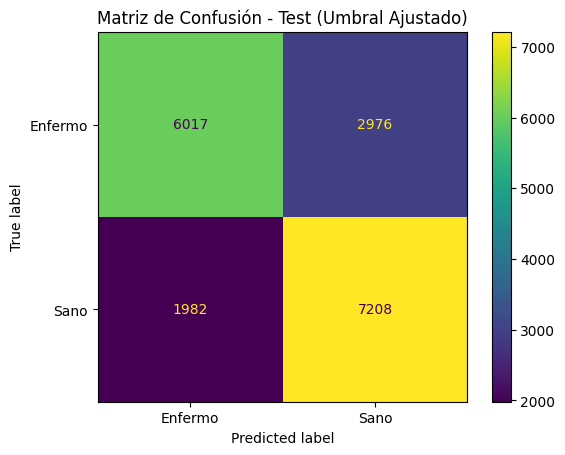

In [65]:
threshold = 0.5   ## Es el mismo que se habia hallado anteriormente

# Aplicar el umbral
y_pred_train_1= (probs_train >= threshold).astype(int)
y_pred_test_1 = (probs_test >= threshold).astype(int)

# Test
print("Clasificación en TEST con umbral =", threshold)
print(classification_report(y_test, y_pred_test_1))

cm_test = confusion_matrix(y_test, y_pred_test_1, labels=[1, 0])
disp_test = ConfusionMatrixDisplay(cm_test, display_labels=['Enfermo', 'Sano'])
disp_test.plot()
plt.title("Matriz de Confusión - Test (Umbral Ajustado)")
plt.show()

In [66]:
threshold1 = 0.6

# Aplicar el umbral
y_pred_train_1= (probs_train >= threshold1).astype(int)
y_pred_test_1 = (probs_test >= threshold1).astype(int)

Clasificación en TEST con umbral = 0.6
              precision    recall  f1-score   support

           0       0.67      0.86      0.76      9190
           1       0.80      0.57      0.67      8993

    accuracy                           0.72     18183
   macro avg       0.74      0.72      0.71     18183
weighted avg       0.74      0.72      0.71     18183



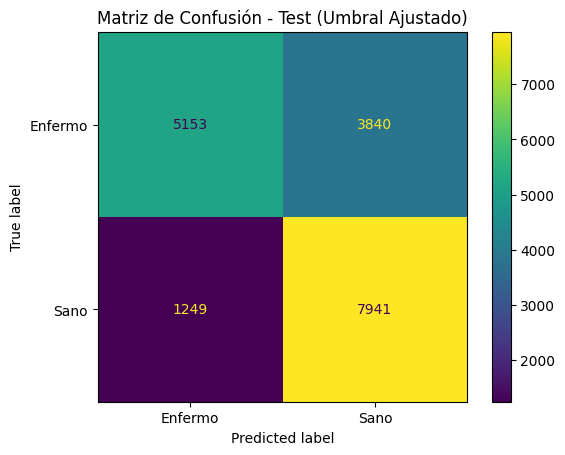

In [67]:
# Test
print("Clasificación en TEST con umbral =", threshold1)
print(classification_report(y_test, y_pred_test_1))

cm_test = confusion_matrix(y_test, y_pred_test_1, labels=[1, 0])
disp_test = ConfusionMatrixDisplay(cm_test, display_labels=['Enfermo', 'Sano'])
disp_test.plot()
plt.title("Matriz de Confusión - Test (Umbral Ajustado)")
plt.show()

In [68]:
threshold2 = 0.4

# Aplicar el umbral
y_pred_train_1= (probs_train >= threshold2).astype(int)
y_pred_test_1 = (probs_test >= threshold2).astype(int)

Clasificación en TEST con umbral = 0.4
              precision    recall  f1-score   support

           0       0.75      0.67      0.70      9190
           1       0.69      0.77      0.73      8993

    accuracy                           0.72     18183
   macro avg       0.72      0.72      0.72     18183
weighted avg       0.72      0.72      0.72     18183



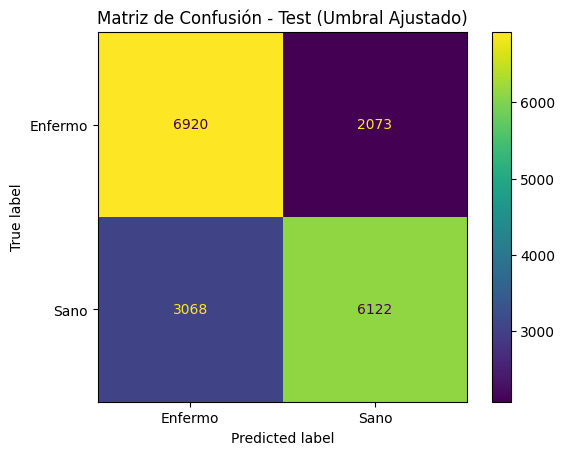

In [69]:
# Test
print("Clasificación en TEST con umbral =", threshold2)
print(classification_report(y_test, y_pred_test_1))

cm_test = confusion_matrix(y_test, y_pred_test_1, labels=[1, 0])
disp_test = ConfusionMatrixDisplay(cm_test, display_labels=['Enfermo', 'Sano'])
disp_test.plot()
plt.title("Matriz de Confusión - Test (Umbral Ajustado)")
plt.show()

Analisis:

Elegir un umbral de 0.6 permite lograr una mayor precisión en la detección de enfermos, reduciendo el número de personas sanas mal diagnosticadas como enfermas (falsos positivos), lo cual es clave para reducir costos en tratamientos y seguimientos innecesarios.

Aunque se incrementan levemente los falsos negativos, el sistema médico contempla procesos adicionales para todos los pacientes, lo cual mitiga los riesgos de omitir un diagnóstico real.

In [73]:
#Analisis de como quedan clasificados en la base de test
prob = best_model.predict_proba(x_test)[:, 1]

clas=['Si cardio' if prob >threshold1 else 'No cardio' if prob < threshold1 else "No identificado" for prob in prob]

clases, count =np.unique(clas, return_counts=True)

count*100/np.sum(count)

array([64.79128857, 35.20871143])

El 64 % estan siendo evaluados con enfermedad, lo cual esta generando ahorros al sistema de salud por el proceso de citas médicas y examenes. Aqui puedo mejorar el proceso